In [1]:
import nuclr
import numpy as np
from tqdm.notebook import trange
import pandas as pd
import torch
import os
from functools import partial
import mup
import torchflame as tf
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

os.makedirs("mup_tests", exist_ok=True)

In [2]:
config = nuclr.config.get_args()
print(config)
trainer = nuclr.train.Trainer(config)

Namespace(MODEL='baseline', WD=0.01, LR=0.01, EPOCHS=50000, N_FOLDS=100, WHICH_FOLDS='0', HIDDEN_DIM=128, DEPTH=2, SEED=0, BATCH_SIZE=4096, INCLUDE_NUCLEI_GT=8, TARGETS_CLASSIFICATION={}, TARGETS_REGRESSION={'binding_semf': 1.0, 'z': 1.0, 'n': 1.0, 'radius': 1.0, 'qa': 1.0, 'qbm': 1.0, 'qbm_n': 1.0, 'qec': 1.0}, SCHED='cosine', LIPSCHITZ='false', TMS='remove', DROPOUT=0.0, FINAL_LR=1e-05, DEV='cpu', WANDB=False)
No sn, sp or binding data, skipping leave one out


In [3]:
model = nuclr.model.NuCLRModel(vocab_size=[100, 100], non_embedded_input_dim=0, hidden_dim=10, output_dim=1, depth=1)

In [4]:
data = nuclr.data.prepare_nuclear_data(config)

No sn, sp or binding data, skipping leave one out


In [36]:
tasks = list(data.output_map.keys())
task_idx = tasks.index('binding_semf')
print(tasks, "binding_semf idx:", task_idx)
ZN = data.X[::len(tasks), :2]
y = data.y[::len(tasks), [task_idx]]
nan_mask = ~torch.isnan(y).flatten()
ZN = ZN[nan_mask]
y = y[nan_mask]

# train test split

ZN, ZN_test, y, y_test = train_test_split(ZN, y, test_size=0.2, random_state=42)
trainloader = DataLoader(TensorDataset(ZN, y), batch_size=len(ZN))
valloader = DataLoader(TensorDataset(ZN_test, y_test), batch_size=len(ZN_test))

['binding_semf', 'z', 'n', 'radius', 'qa', 'qbm', 'qbm_n', 'qec'] binding_semf idx: 0


In [6]:
#### set up things with mup

def update_readout(model):
    """function that takes our model and returns all readout layers"""
    readout_shape = model.readout.weight.shape
    model.readout = mup.MuReadout(readout_shape[1], readout_shape[0])
    return [model.readout]

"""function that takes a width and returns a model"""
model_fn = lambda w: tf.mup.make_mup(
    nuclr.model.NuCLRModel, # model class
    update_readout, # function that updates readout layers
    dict(
        vocab_size=data.vocab_size[:2],
        non_embedded_input_dim=0,
        hidden_dim=w,
        output_dim=1,
        depth=1,
    ), # all model args, used for to initialize model
    dict(hidden_dim=16), # base model args
)


In [ ]:
### make coord check plot
tf.mup.coord_check(
    model_fn,
    mup=True,
    lr=1e-1,
    train_loader=trainloader,
    nsteps=4,
    nseeds=2,
    legend=True,
    lossfn="mse",
    plotdir="mup_tests",
)

In [66]:
# train many models to check whether lr transfers
widths = [16, 128, 512, 1024]
lrs = (np.array([1, 0.8, 0.5, 1e-1, 2e-2, 1.5e-2, 1e-2]) * 1e-1).round(8)
seeds = range(2)
df = tf.mup.make_histories(
    model_fn,
    trainloader,
    widths,
    lrs,
    seeds,
    valloader=valloader,
    savefile="mup_tests/mup_history.csv",
    lossfn="mse",
    epochs=100,
)

lr: 0.001, width: 1024, seed: 1 epoch:990, loss:0.00021478059352375567, val_loss:0.0009356201044283807: 100%|██████████| 56/56 [19:56<00:00, 21.36s/it] 


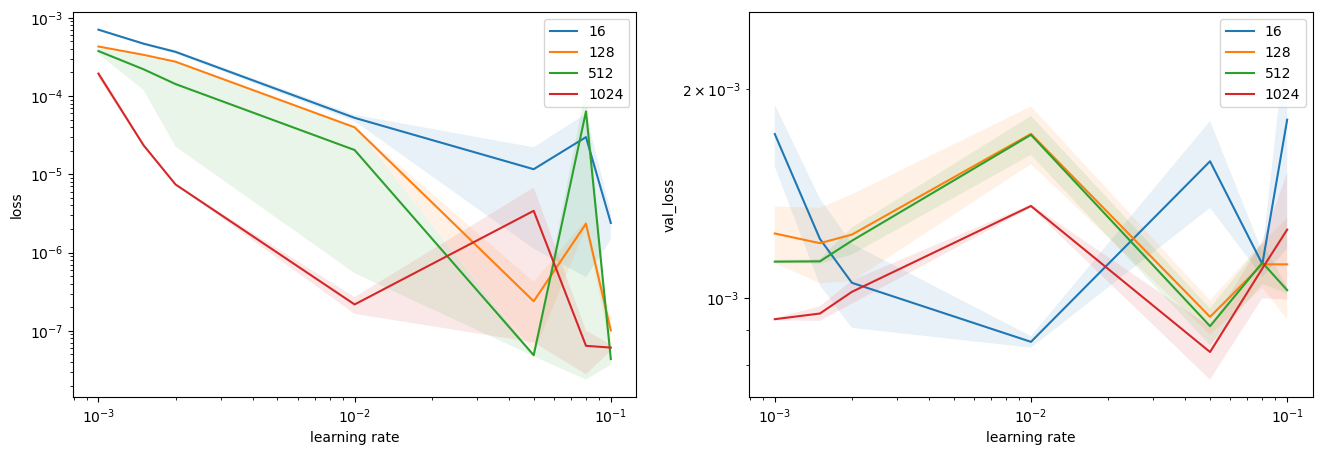

In [12]:
tf.mup.make_transfer_plot("mup_tests/mup_history.csv", savefile="mup_tests/mup_final_loss.png")

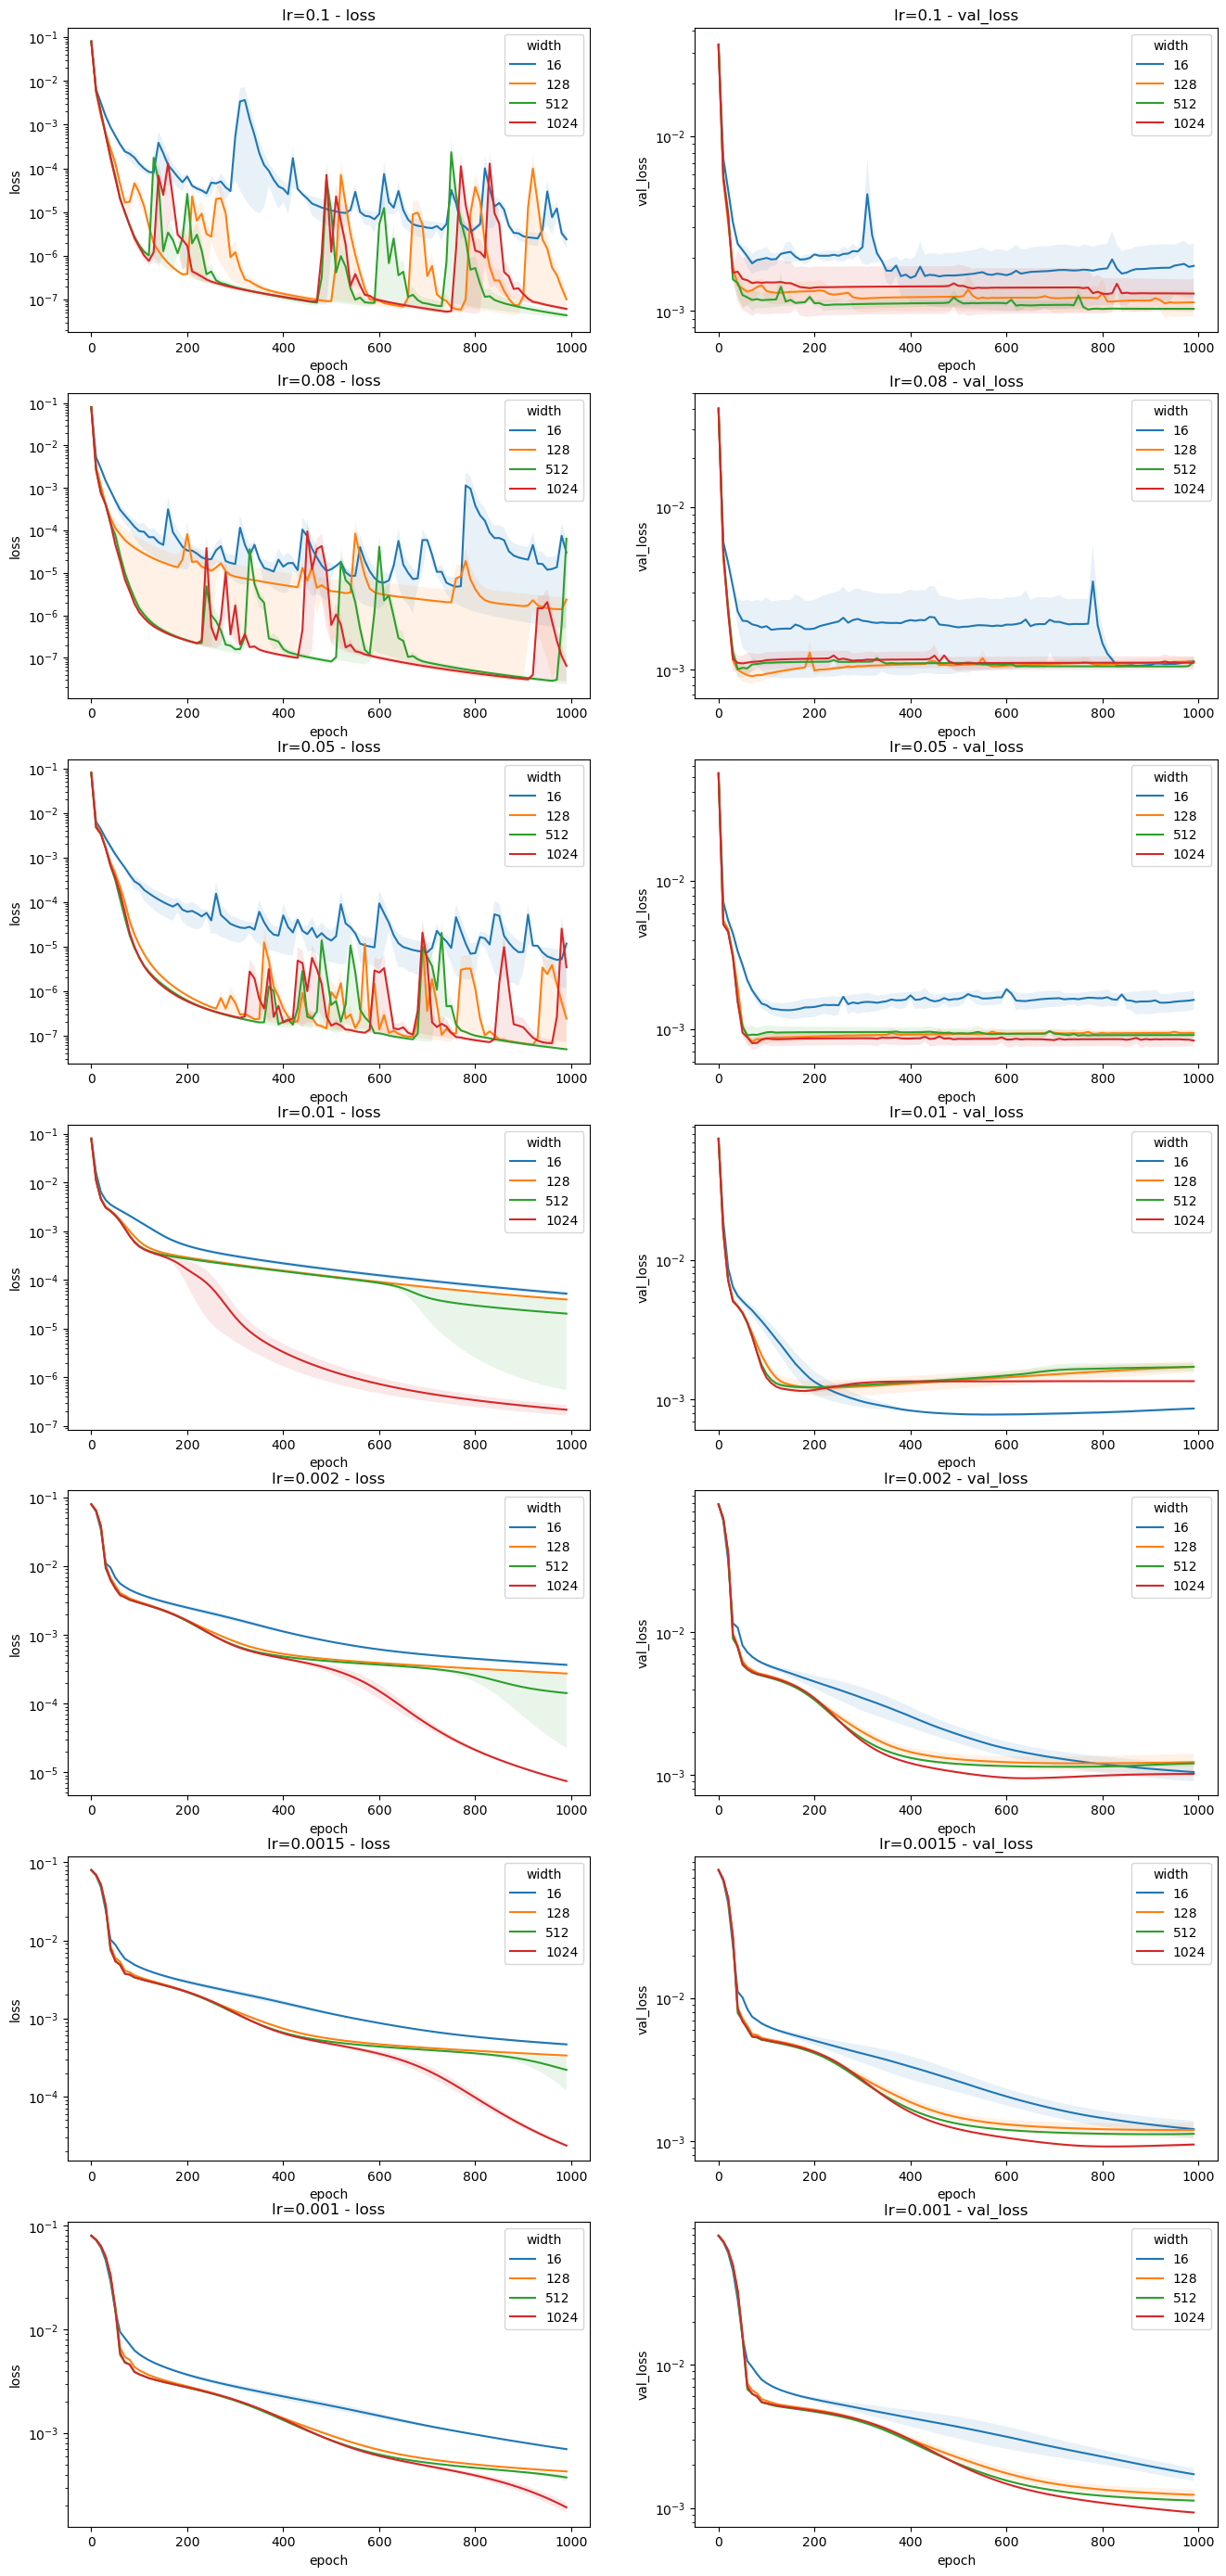

In [16]:
tf.mup.plot_history("mup_tests/mup_history.csv", savefile="mup_tests/mup_histories.png")

In [ ]:
# depth, lr, weight decay, scheduler (sched details), batch size, optimizer details, init parameters, scaling factors.

In [21]:
seeds

(range(0, 2),)

In [37]:
#def make_histories_wd
from tqdm.notebook import trange
model_fn,
trainloader,
widths=[16, 128, 512, 1024]
wds=10.**(-np.arange(1., 5.))
seeds=range(2)
savefile=None
lossfn="mse"
epochs=100
lr=1e-2
"""train models with different widths and weight_decays and save history to df."""

pbar = trange(len(widths) * len(seeds) * len(wds))

histories = []
for wd in wds:
    for width in widths:
        for seed in seeds:
            row = {"lr": lr, "width": width, "seed": seed, "wd": wd}
            pbar.update(1)
            torch.manual_seed(seed)
            model = model_fn(width)
            optimizer = tf.get_optimizer(model, lr, use_mup=True, weight_decay=wd)
            flame_model = tf.Flame(model, optimizer, device="cuda", loss=lossfn)
            flame_model.fit(
                trainloader, valloader=valloader, epochs=epochs, track_loss=10
            )
            for k, v in flame_model.history.items():
                row[k] = v
            histories.append(row)
            desc = f"lr: {lr}, width: {width}, seed: {seed}"
            desc += ",".join(
                [f" {k}:{v[-1]}" for k, v in flame_model.history.items()]
            )
            pbar.set_description(desc)
pbar.close()

# export to csv
df = pd.DataFrame(histories)
if savefile:
    if savefile.endswith(".csv"):
        savefile = savefile[:-4]
    df.to_csv(f"{savefile}.csv")

  0%|          | 0/32 [00:00<?, ?it/s]

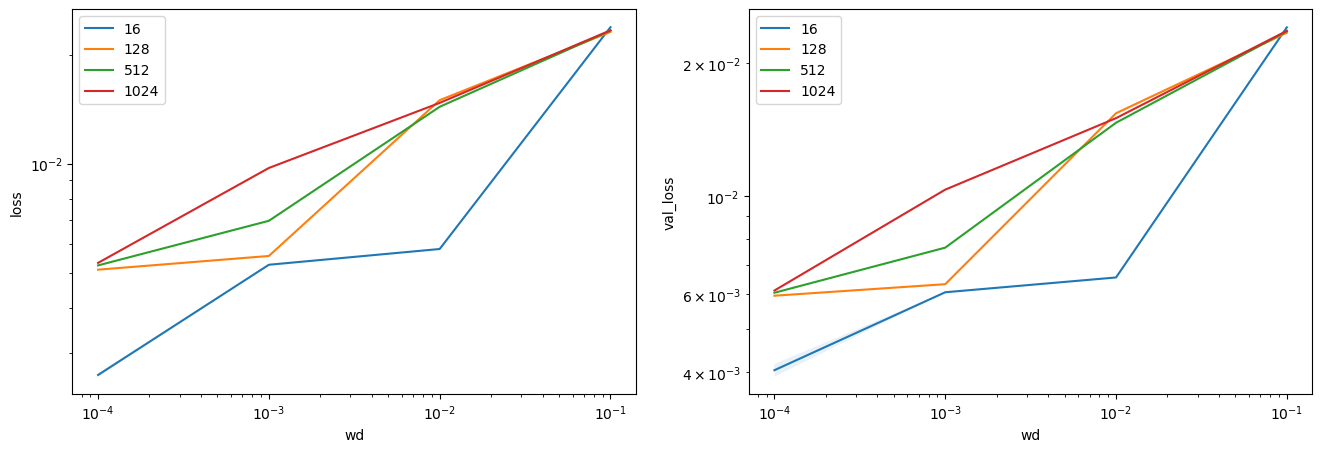

In [38]:
tf.mup.make_transfer_plot(df, savefile="mup_tests/mup_final_loss_wd.png",transfer_key="wd")

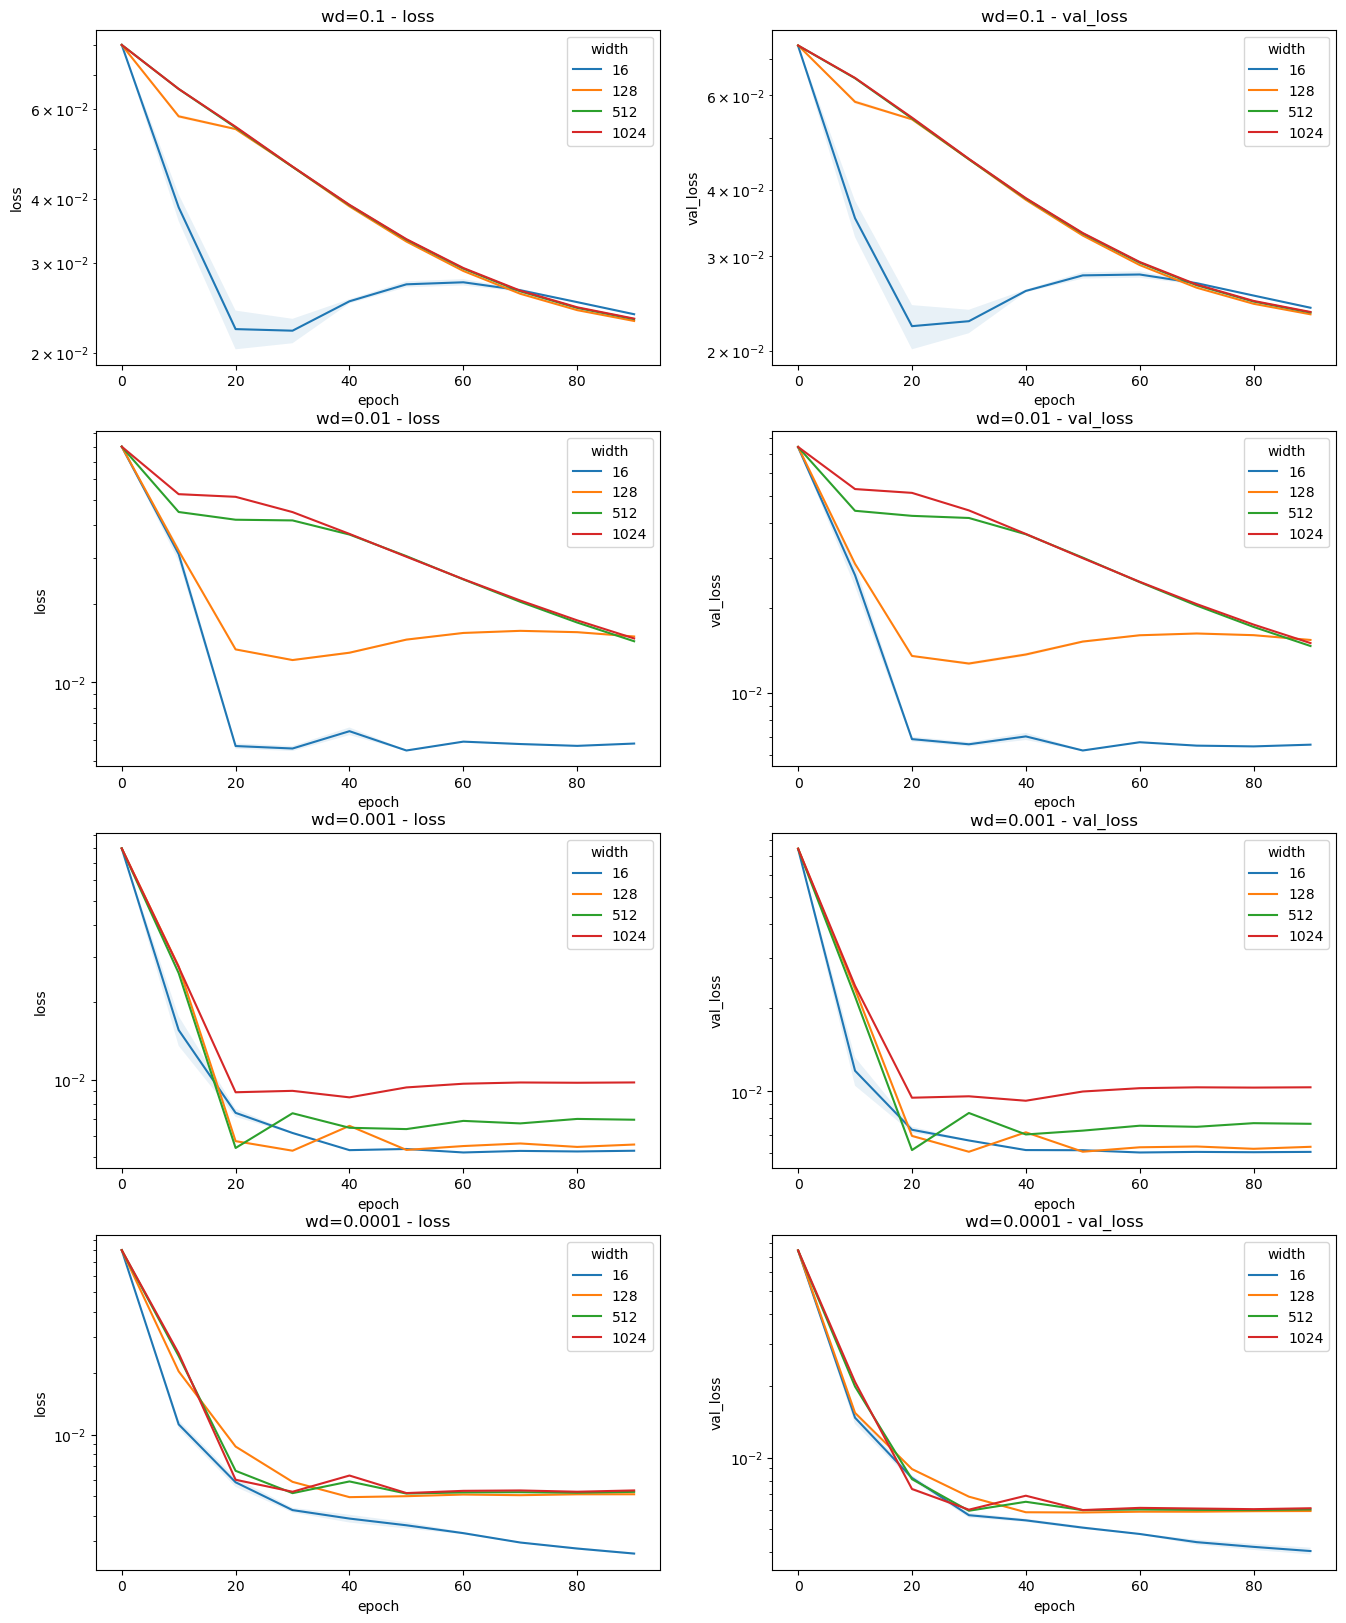

In [40]:
tf.mup.plot_history(df, savefile="mup_tests/mup_history_wd.png",transfer_key="wd")